# Integrated Metadata-Data API Example

This notebook gives an example of exploring the RIMReP DMS with the metadata API, and then collecting desired data with the data API.

In [1]:
# First, install and load the required packages.

import subprocess

packages = [
    'pystac_client',
    'owslib',
    'geopandas',
    'pyarrow',
    'dask_geopandas',
    's3fs'
]

for package in packages:
    try:
        subprocess.check_call(['pip', 'install', package])
        print(f'Successfully installed {package}')
    except subprocess.CalledProcessError as e:
        print(f'Error occurred while installing {package}: {e}')

In [2]:
from getpass import getpass
import pystac_client
import re

from owslib.ogcapi.features import Features
from owslib.util import Authentication

from geopandas import GeoDataFrame
import pyarrow.compute as pc
import pyarrow as pa
import dask_geopandas
import pandas as pd

## Connect to metadata API

We first connect to the metadata API by retrieving the root catalog

To do this, you will need to go to https://dashboard.staging.reefdata.io/ and copy your Authentication token.
This can then be pasted into the password prompt.

In [3]:
# Go to https://dashboard.staging.reefdata.io/, copy your API key and paste into password box

# Create the client
api = pystac_client.Client.open(
    url="https://stac.staging.reefdata.io/",
    headers={
        'Authorization': f"Bearer {getpass()}"
    },
    ignore_conformance=True
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pystac_client/client.py:177: FutureWarning: The `ignore_conformance` option is deprecated and will be removed in the next major release. Instead use `set_conforms_to` or `add_conforms_to` to control behavior.
  warnings.warn(


## Search for a dataset with the required data
Filter by spatial bounds and Oceans keyword

In [4]:
# Set geometry bounds you want to search within
geom = {
    "type": "Polygon",
    "coordinates": [
        [[146.5, -19], [146.5, -18.5], [147, -18.5], [147, -19], [146.5, -19]]
    ],
}

# Search the API
results = api.search(
    max_items=15,
    limit=5,
    intersects=geom,
    datetime="2012-05-01/2012-05-02",
    query={"themes": {"eq": [{'scheme': 'https://wiki.esipfed.org/ISO_19115-3_Codelists#MD_TopicCategoryCode',
                              'concepts': [{'id': 'oceans', 'title': 'Oceans'}]}]}}
)

# Print the id of every found item that has 'Oceans' as a keyword theme
for item in results.items():
    print(item.id)


aims-sst
gbrmpa-complete-gbr-features


In [5]:
# Choose the dataset you want to work with - this chooses the first dataset listed which is the AIMS SST data
items_list = list(results.items())
chosen_item = items_list[0]

# Access the ID of the chosen dataset
chosen_dataset_id = chosen_item.id
print(chosen_dataset_id)

aims-sst


## Connect to the data API and get the data

The item returned by the metadata API contains a link pointing to the corresponding collection in the data API. This can be used to collect the data.

In [6]:
# Inspect item to get link to the data API
link = chosen_item.get_single_link(rel="describedby").href

# Parse the link as data_api_url/collections/collection_id
data_api_url, _, collection_id = re.findall("(?:[^/]|//)+", link)

# Enter token to get authorisation for the data API
data_api = Features("https://pygeoapi.staging.reefdata.io/", headers= {'Authorization': f'Bearer {getpass()}'})


collected_data = data_api.collection_items(
    collection_id,
    bbox=[146.5, -19, 147, -18.5],
    datetime="2012-05-01T00:00:00Z/2012-05-02T00:00:00Z",
    qc_flag=1,
    limit=1000,
)

print(len(collected_data['features']))


424


## Plot the data
The simple example here is plotting a timeseries of the temperatures collected on 01/05/2012 in the area of Orpheus Island

subsite
HAVSL1     Axes(0.125,0.2;0.775x0.68)
ORPHFL1    Axes(0.125,0.2;0.775x0.68)
ORPHFL2    Axes(0.125,0.2;0.775x0.68)
Name: qc_val, dtype: object

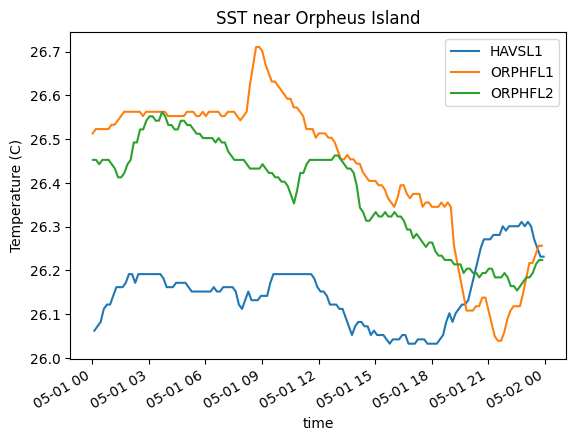

In [7]:
gdf = GeoDataFrame.from_features(collected_data)
gdf.time = pd.to_datetime(gdf.time)  # Convert from string to datetime

gdf.set_index("time", inplace=True)
gdf.groupby("subsite")["qc_val"].plot(
    legend=True, ylabel="Temperature (C)", title=f"SST near Orpheus Island"
)

## Get the direct link to the data 
The assets of the STAC item will contain a link to the data we are looking for

In [8]:
item_assets = chosen_item.get_assets()
link_to_data = item_assets["data"].href

## Collect data from direct access
- With [dask-geopandas](https://dask-geopandas.readthedocs.io/en/stable/)

In [9]:
# Build the filter
data_filter = [
    ("lat", ">=", -19),
    ("lon", ">=", 146.5),
    ("lat", "<=", -18.5),
    ("lon", "<=", 147),
    ("time", ">=", pd.to_datetime("2012-05-01T00:00:00Z")),
    ("time", "<=", pd.to_datetime("2012-05-02T00:00:00Z")),
    ("qc_flag", "==", 1)
]

# Read the data
df = dask_geopandas.read_parquet(
    link_to_data,
    filters=[data_filter],
    columns=["time", "subsite", "qc_val"],
    index=False,
    storage_options={"anon": True}, # no authentication needed for this s3 bucket
).compute()

df

,time,subsite,qc_val
0,2012-05-01 23:51:47+00:00,ORPHFL2,26.2238
1,2012-05-01 23:31:47+00:00,ORPHFL2,26.2138
2,2012-05-01 20:21:47+00:00,ORPHFL2,26.1940
3,2012-05-01 20:11:47+00:00,ORPHFL2,26.1940
4,2012-05-01 20:01:47+00:00,ORPHFL2,26.2039
...,...,...,...
137,2012-05-01 12:16:21+00:00,HAVSL1,26.1517
138,2012-05-01 12:26:21+00:00,HAVSL1,26.1418
139,2012-05-01 12:36:21+00:00,HAVSL1,26.1219
140,2012-05-01 12:46:21+00:00,HAVSL1,26.1219


- Or with [pyarrow](https://arrow.apache.org/docs/python/index.html)

In [10]:
# Build the filter
lon = pc.field("lon")
lat = pc.field("lat")
time = pc.field("time")
qc_flag = pc.field("qc_flag")

data_filter = (
    (lat >= -19) &
    (lon >= 146.5) &
    (lat <= -18.5) &
    (lon <= 147) &
    (time >= pd.to_datetime("2012-05-01T00:00:00Z")) &
    (time <= pd.to_datetime("2012-05-02T00:00:00Z")) &
    (qc_flag == 1)
)

ds = pa.dataset.dataset(link_to_data)
table = ds.to_table(filter=data_filter,
                    columns=["time", "subsite", "qc_val"])

df = table.to_pandas()

df

,time,subsite,qc_val
0,2012-05-01 23:51:47+00:00,ORPHFL2,26.2238
1,2012-05-01 23:31:47+00:00,ORPHFL2,26.2138
2,2012-05-01 20:21:47+00:00,ORPHFL2,26.1940
3,2012-05-01 20:11:47+00:00,ORPHFL2,26.1940
4,2012-05-01 20:01:47+00:00,ORPHFL2,26.2039
...,...,...,...
419,2012-05-01 12:16:21+00:00,HAVSL1,26.1517
420,2012-05-01 12:26:21+00:00,HAVSL1,26.1418
421,2012-05-01 12:36:21+00:00,HAVSL1,26.1219
422,2012-05-01 12:46:21+00:00,HAVSL1,26.1219


The two previous examples are equivalent, but some things may be easier to do with dask while other things may be easier with pyarrow.

Finally, let's plot the data.

subsite
HAVSL1     Axes(0.125,0.2;0.775x0.68)
ORPHFL1    Axes(0.125,0.2;0.775x0.68)
ORPHFL2    Axes(0.125,0.2;0.775x0.68)
Name: qc_val, dtype: object

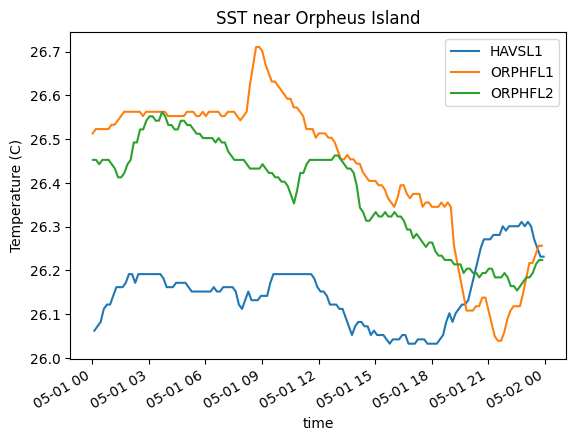

In [11]:
df.set_index("time", inplace=True)
df.groupby("subsite")['qc_val'].plot(
    legend=True, ylabel="Temperature (C)", title=f"SST near Orpheus Island"
)